In [ ]:
import intel_extension_for_pytorch as ipex
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch
from tqdm import tqdm
from typing import Tuple
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 64
N_CHANNELS = 3
EPOCHS = 30
LATENT_DIM = 100
DG_TRAIN_RATIO = 5
LAMBDA_GP = 50

### Dataset

In [3]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

trainset = CIFAR10(root='../data', train=True,  transform=transformer, download=True)
testset  = CIFAR10(root='../data', train=False, transform=transformer, download=True)

trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True)
testloader  = DataLoader(testset, BATCH_SIZE, shuffle=True)

classes = {i:name for i, name in enumerate(trainset.classes)}
classes

Files already downloaded and verified
Files already downloaded and verified


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [4]:
def show_imgs(imgs: torch.Tensor, labels: torch.Tensor):
    imgs = imgs.cpu().detach().clone().permute(0, 2, 3, 1)
    labels = labels.cpu().detach().clone()
    imgs = (imgs + 1)/2
    n = len(labels)
    rows, cols = n // 4, 4
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i-1])
        plt.title(classes[labels[i-1].item()])
        plt.axis(False)
    plt.show()

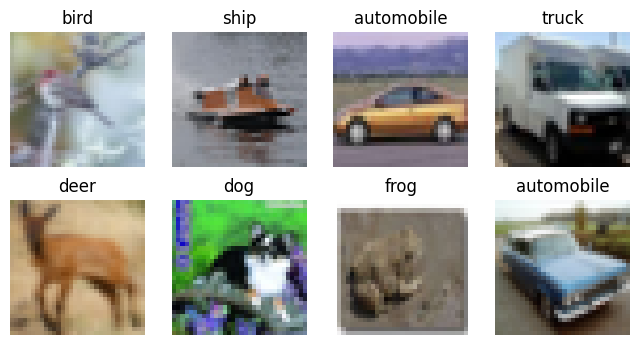

In [5]:
imgs, labels = next(iter(trainloader))
show_imgs(imgs[:8], labels[:8])

### Model

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_channels:int, n_classes: int):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=latent_dim)
        
        self.model = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
            self._block(4, latent_dim, 256),
            self._block(8, 256, 128),
            self._block(16, 128, 64),
            nn.UpsamplingBilinear2d(size=(32, 32)),
            nn.Conv2d(64, n_channels, 3, 1, 'same', bias=False),          
            nn.Tanh())
        
    def _block(self, new_size:int, in_channels:int, out_channels:int, 
               kernel_size:int=4, stride:int=2, padding:int=1,
               momentum:float=0.9, negative_slope:float=0.2) -> nn.Module:
        return nn.Sequential(
            nn.UpsamplingBilinear2d(size=(new_size, new_size)),
            nn.Conv2d(in_channels, out_channels,
                      kernel_size, stride, padding, bias=False),          
            nn.BatchNorm2d(num_features=out_channels, momentum=momentum),
            nn.LeakyReLU(negative_slope=negative_slope))

    def forward(self, labels):
        cls_embds = self.embeddings(labels)
        eps = torch.randn_like(cls_embds)
        return self.model(cls_embds + eps)

In [7]:
"""class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_channels: int, n_classes: int ):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=latent_dim)
        
        self.model = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
            self._block(latent_dim, 256),
            self._block(256, 128, 4, 2, 1),
            self._block(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, n_channels, 4, 2, 1),        
            nn.Tanh())
        
    def _block(self, in_channels:int, out_channels:int, 
               kernel_size:int=4, stride:int=2, padding:int=0,
               momentum:float=0.9, negative_slope:float=0.2) -> nn.Module:
        return nn.Sequential(       
            nn.ConvTranspose2d(in_channels, out_channels,
                               kernel_size, stride, padding),
            nn.BatchNorm2d(num_features=out_channels, momentum=momentum),
            nn.LeakyReLU(negative_slope=negative_slope))

    def forward(self, labels):
        cls_embds = self.embeddings(labels)
        eps = torch.randn_like(cls_embds)
        return self.model(cls_embds + eps)"""

In [8]:
class Critic(nn.Module):
    def __init__(self, n_classes: int, img_shape: Tuple):
        super(Critic, self).__init__()
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=torch.prod(img_shape))
        self.model = nn.Sequential(
            self._block(img_shape[0]*2,  64, 3, 2, 1),
            self._block(64, 128, 3, 2, 1),
            self._block(128, 256, 3, 2, 1),

            nn.Conv2d(in_channels=256,
                      out_channels=1,
                      kernel_size=4,
                      stride=1, padding=0), 
            nn.Flatten())
        
    def _block(self, in_channels:int, out_channels:int, kernel_size:int, 
               stride:int, padding:int, momentum:float=0.9,
               negative_slope:float=0.2, dropout:float=0.1) -> nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size, stride, padding),
            nn.BatchNorm2d(num_features=out_channels, momentum=momentum),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Dropout2d(p=dropout))
        
    def forward(self, imgs, labels):
        embds = self.embeddings(labels).view(imgs.shape)
        concat = torch.cat((imgs, embds), dim=1)
        return self.model(concat)

In [9]:
class CWGAN_GP(nn.Module):
    def __init__(self, generator, critic, LAMBDA_GP: float=10):
        super(CWGAN_GP, self).__init__()
        self.generator = generator
        self.critic = critic
        self.g_optimizer = None
        self.c_optimizer = None
        self.LAMBDA_GP = LAMBDA_GP

    def forward(self, labels):
        return self.generator(labels)
    
    def compile(self, g_optimizer, c_optimizer):
        self.g_optimizer = g_optimizer
        self.c_optimizer = c_optimizer
    
    def gradient_penalty(self, real_imgs, fake_imgs, labels):
        alpha = torch.randn((*real_imgs.shape[:1], 1, 1, 1)).to(real_imgs.device)
        diff = fake_imgs - real_imgs
        interpolation = real_imgs + alpha * diff
        preds = self.critic(interpolation, labels)
        grad_outputs = torch.ones_like(preds)
        gradients = torch.autograd.grad(
            outputs=preds,
            inputs=interpolation,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True)[0]
        
        gradients = gradients.view(labels.shape[0], -1)
        grad_norm = gradients.norm(2, 1)
        return ((grad_norm-1)**2).mean()

### Model Initialization

In [10]:
device = 'xpu' if ipex.xpu.is_available() else 'cpu'

generator = Generator(LATENT_DIM, N_CHANNELS, len(classes))
critic = Critic(len(classes), torch.tensor(imgs[0].shape))

g_optimizer = optim.Adam(generator.parameters())
c_optimizer = optim.Adam(critic.parameters())

model = CWGAN_GP(generator, critic, LAMBDA_GP)
model.compile(g_optimizer, c_optimizer)
print(ipex.xpu.get_device_name())

Intel(R) Arc(TM) A770 Graphics


### Training Implementation Scheme

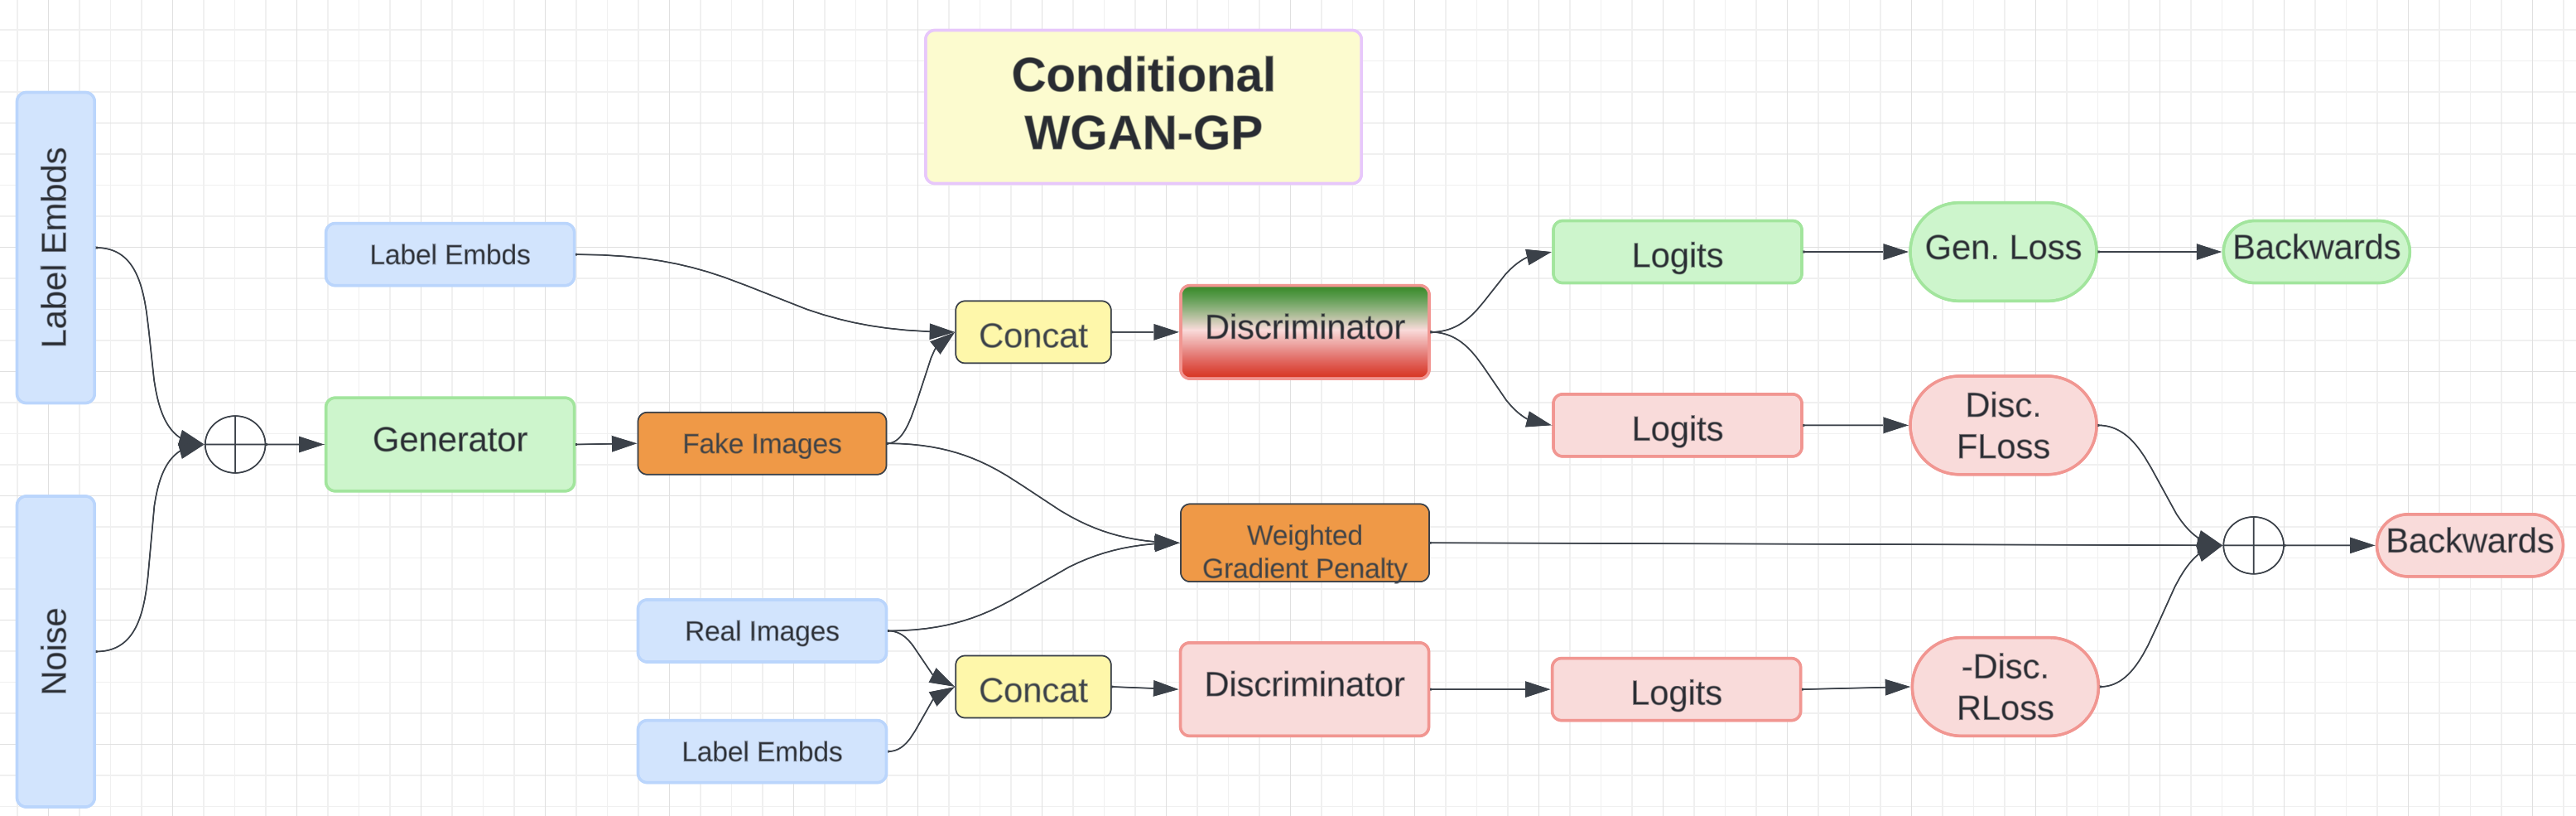

In [11]:
def train_step(model: nn.Module, trainloader: DataLoader, 
               device: torch.device, DG_TRAIN_RATIO:int=3):
    model.train()
    # model, model.g_optimizer = ipex.optimize(model, optimizer=model.g_optimizer)
    # model, model.c_optimizer = ipex.optimize(model, optimizer=model.c_optimizer)
    loss = {'d_loss':.0, 'g_loss':.0, 'd_wass_loss':.0, 'd_gp':.0}
    
    for i, (real_imgs, labels) in enumerate(tqdm(trainloader)):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        
        # *******************
        # Train Critic
        # *******************
        
        # setting grads to 0 after last generator backprop
        model.c_optimizer.zero_grad()
        
        # generated images conditioned on labels
        fake_imgs = model.generator(labels)
        
        # critic output based on fake&real images
        d_fake_logits = model.critic(fake_imgs.detach(), labels)
        d_real_logits = model.critic(real_imgs, labels)
        d_gp = model.gradient_penalty(real_imgs, 
            fake_imgs.detach().clone().requires_grad_(True),labels)
        d_wass_loss = d_fake_logits.mean() - d_real_logits.mean()
        d_loss = d_wass_loss + d_gp * model.LAMBDA_GP
        
        # critic backpropagation
        d_loss.backward()
        model.c_optimizer.step()

        loss['d_loss'] += d_loss.item()
        loss['d_gp'] += d_gp.item()
        loss['d_wass_loss'] += d_wass_loss.item()
        
        
        if (i+1) % DG_TRAIN_RATIO == 0:
            # ***************
            # Train Generator
            # ***************
            
            # generator backpropagation        
            model.g_optimizer.zero_grad()
            # print(fake_imgs.shape)
            # fake_imgs = model.generator(labels)
            d_fake_logits = model.critic(fake_imgs, labels)
            g_loss = -torch.mean(d_fake_logits)
            
            loss['g_loss'] += g_loss.item()

            g_loss.backward()
            model.g_optimizer.step()

    n_batches = len(trainloader)
    for k in loss.keys():
        loss[k] /= n_batches
    loss['g_loss'] *= DG_TRAIN_RATIO
    return loss

In [12]:
def test_step(model: nn.Module, testloader: DataLoader,
              device: torch.device):
    loss = {'d_loss':.0, 'g_loss':.0}
    model.eval()
    with torch.inference_mode():
        for real_imgs, labels in tqdm(testloader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

            fake_imgs = model.generator(labels)
            d_fake_logits = model.critic(fake_imgs, labels)
            d_real_logits = model.critic(real_imgs, labels)
            d_loss = d_fake_logits.mean() - d_real_logits.mean()
            g_loss = -torch.mean(d_fake_logits)
            
            loss['d_loss'] += d_loss.item()
            loss['g_loss'] += g_loss.item()
            
        n_batches = len(testloader)
        loss['d_loss'] /= n_batches
        loss['g_loss'] /= n_batches
        
    return loss

In [15]:
def train(model: nn.Module, trainloader: DataLoader,
          testloader: DataLoader, device: torch.device, 
          EPOCHS: int, DG_TRAIN_RATIO: int=3):
    model = model.to(device)
    results = {'train_loss':{'d_loss':[], 'g_loss':[], 'd_wass_loss':[], 'd_gp':[]},
               'test_loss':{'d_loss':[], 'g_loss':[]}}
    
    gif_rand_labels = torch.randint(0, 10, (64,)).to(device)
    gif_gen_imgs = []
    
    for epoch in range(1, EPOCHS+1):
        print(f"\nEPOCH ===================================> {epoch:3d}/{EPOCHS}")
        print("******************** Training ********************")
        train_results = train_step(model, trainloader, device, DG_TRAIN_RATIO)
        print(f"Generator Loss: ------------------------> {train_results['g_loss']:.4f}")
        print(f"Critic Loss: ---------------------------> {train_results['d_loss']:.4f}")
        print(f"Critic Wasserstein Loss: ---------------> {train_results['d_wass_loss']:.4f}")
        print(f"Critic Gradient Penalty: ---------------> {train_results['d_gp']:.4f}")

        print("******************** Testing ********************")
        test_results = test_step(model, testloader, device)
        print(f"Generator Loss: ------------------------> {test_results['g_loss']:.4f}")
        print(f"Critic Loss: ---------------------------> {test_results['d_loss']:.4f}")
        
        # saving results
        for k, v in train_results.items():
            results['train_loss'][k].append(v)
        for k, v in test_results.items():
            results['test_loss'][k].append(v)
        
        # gif frame generation
        model.eval()
        with torch.inference_mode():
            gen_imgs = make_grid(model(gif_rand_labels).to(device='cpu')).permute(1, 2, 0).numpy()
            gen_imgs = ((gen_imgs + 1) * 127.5).astype(np.uint8)
            gif_gen_imgs.append(gen_imgs)
    
        if epoch % 5 == 0:
            # save the training GIF after all frames have been collected
            imageio.mimsave(f'../gifs/cifar10_cwgan_gp.gif', 
                            gif_gen_imgs, loop=65535)
            # save checkpoint
            torch.save({
                'epoch':epoch,
                'model_state_dict':model.state_dict(),
                'optimizers_state_dict': [model.g_optimizer.state_dict(),
                                          model.c_optimizer.state_dict()],
                'losses': results},  f'../models/cifar10_cwgan_gp.pth')
            
    imageio.mimsave(f'../gifs/cifar10_cwgan_gp_training.gif', gif_gen_imgs, loop=65535)
    return results

In [16]:
results = train(model, trainloader, testloader, device, EPOCHS, DG_TRAIN_RATIO)


EPOCH ===================================>   1/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.41it/s]


Generator Loss: ------------------------> -1.4201
Critic Loss: ---------------------------> 1.2117
Critic Wasserstein Loss: ---------------> 0.0071
Critic Gradient Penalty: ---------------> 0.0241
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 45.78it/s]


Generator Loss: ------------------------> -0.3554
Critic Loss: ---------------------------> -0.0257

EPOCH ===================================>   2/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.59it/s]


Generator Loss: ------------------------> 0.3778
Critic Loss: ---------------------------> -1.5675
Critic Wasserstein Loss: ---------------> -1.9456
Critic Gradient Penalty: ---------------> 0.0076
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.26it/s]


Generator Loss: ------------------------> -0.3952
Critic Loss: ---------------------------> -0.0228

EPOCH ===================================>   3/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.70it/s]


Generator Loss: ------------------------> 3.5320
Critic Loss: ---------------------------> -3.3435
Critic Wasserstein Loss: ---------------> -3.6733
Critic Gradient Penalty: ---------------> 0.0066
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.66it/s]


Generator Loss: ------------------------> -0.7065
Critic Loss: ---------------------------> -0.0034

EPOCH ===================================>   4/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.86it/s]


Generator Loss: ------------------------> 6.8547
Critic Loss: ---------------------------> -7.1365
Critic Wasserstein Loss: ---------------> -7.6835
Critic Gradient Penalty: ---------------> 0.0109
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.58it/s]


Generator Loss: ------------------------> -0.9630
Critic Loss: ---------------------------> -0.0056

EPOCH ===================================>   5/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.70it/s]


Generator Loss: ------------------------> 9.5512
Critic Loss: ---------------------------> -10.1083
Critic Wasserstein Loss: ---------------> -11.1344
Critic Gradient Penalty: ---------------> 0.0205
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.92it/s]


Generator Loss: ------------------------> -1.3701
Critic Loss: ---------------------------> 0.0537

EPOCH ===================================>   6/30
******************** Training ********************


100%|██████████| 782/782 [00:33<00:00, 23.03it/s]


Generator Loss: ------------------------> 10.2468
Critic Loss: ---------------------------> -10.4605
Critic Wasserstein Loss: ---------------> -11.3106
Critic Gradient Penalty: ---------------> 0.0170
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 50.16it/s]


Generator Loss: ------------------------> -1.7335
Critic Loss: ---------------------------> -0.0058

EPOCH ===================================>   7/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.77it/s]


Generator Loss: ------------------------> 10.7845
Critic Loss: ---------------------------> -10.3753
Critic Wasserstein Loss: ---------------> -11.3969
Critic Gradient Penalty: ---------------> 0.0204
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.77it/s]


Generator Loss: ------------------------> -1.9392
Critic Loss: ---------------------------> -0.0737

EPOCH ===================================>   8/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.90it/s]


Generator Loss: ------------------------> 0.8752
Critic Loss: ---------------------------> -4.2131
Critic Wasserstein Loss: ---------------> -5.0057
Critic Gradient Penalty: ---------------> 0.0159
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.60it/s]


Generator Loss: ------------------------> -1.7400
Critic Loss: ---------------------------> -0.1613

EPOCH ===================================>   9/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.96it/s]


Generator Loss: ------------------------> -4.1300
Critic Loss: ---------------------------> -3.3427
Critic Wasserstein Loss: ---------------> -3.7338
Critic Gradient Penalty: ---------------> 0.0078
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 50.18it/s]


Generator Loss: ------------------------> -1.4109
Critic Loss: ---------------------------> -0.1582

EPOCH ===================================>  10/30
******************** Training ********************


100%|██████████| 782/782 [00:33<00:00, 23.02it/s]


Generator Loss: ------------------------> 2.0776
Critic Loss: ---------------------------> -5.4135
Critic Wasserstein Loss: ---------------> -5.9093
Critic Gradient Penalty: ---------------> 0.0099
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.98it/s]


Generator Loss: ------------------------> -1.6142
Critic Loss: ---------------------------> -0.1742

EPOCH ===================================>  11/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.88it/s]


Generator Loss: ------------------------> 2.3312
Critic Loss: ---------------------------> -5.5310
Critic Wasserstein Loss: ---------------> -6.2191
Critic Gradient Penalty: ---------------> 0.0138
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.17it/s]


Generator Loss: ------------------------> -1.9582
Critic Loss: ---------------------------> -0.1409

EPOCH ===================================>  12/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.65it/s]


Generator Loss: ------------------------> 5.2650
Critic Loss: ---------------------------> -5.2644
Critic Wasserstein Loss: ---------------> -6.0652
Critic Gradient Penalty: ---------------> 0.0160
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.25it/s]


Generator Loss: ------------------------> -2.2922
Critic Loss: ---------------------------> -0.1622

EPOCH ===================================>  13/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.72it/s]


Generator Loss: ------------------------> 4.8049
Critic Loss: ---------------------------> -4.4282
Critic Wasserstein Loss: ---------------> -5.0885
Critic Gradient Penalty: ---------------> 0.0132
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.31it/s]


Generator Loss: ------------------------> -2.3849
Critic Loss: ---------------------------> -0.1169

EPOCH ===================================>  14/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 23.00it/s]


Generator Loss: ------------------------> 6.0820
Critic Loss: ---------------------------> -4.8179
Critic Wasserstein Loss: ---------------> -5.4524
Critic Gradient Penalty: ---------------> 0.0127
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 50.08it/s]


Generator Loss: ------------------------> -2.5765
Critic Loss: ---------------------------> -0.0913

EPOCH ===================================>  15/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.82it/s]


Generator Loss: ------------------------> 6.6620
Critic Loss: ---------------------------> -5.8828
Critic Wasserstein Loss: ---------------> -6.5010
Critic Gradient Penalty: ---------------> 0.0124
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.37it/s]


Generator Loss: ------------------------> -2.7075
Critic Loss: ---------------------------> -0.1109

EPOCH ===================================>  16/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.79it/s]


Generator Loss: ------------------------> 6.7003
Critic Loss: ---------------------------> -6.4872
Critic Wasserstein Loss: ---------------> -7.1801
Critic Gradient Penalty: ---------------> 0.0139
******************** Testing ********************


100%|██████████| 157/157 [00:06<00:00, 25.96it/s]


Generator Loss: ------------------------> -2.9255
Critic Loss: ---------------------------> -0.1956

EPOCH ===================================>  17/30
******************** Training ********************


100%|██████████| 782/782 [00:59<00:00, 13.16it/s]


Generator Loss: ------------------------> 8.5734
Critic Loss: ---------------------------> -7.0709
Critic Wasserstein Loss: ---------------> -7.8482
Critic Gradient Penalty: ---------------> 0.0155
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.87it/s]


Generator Loss: ------------------------> -2.7886
Critic Loss: ---------------------------> -0.1172

EPOCH ===================================>  18/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.81it/s]


Generator Loss: ------------------------> 7.9056
Critic Loss: ---------------------------> -6.8838
Critic Wasserstein Loss: ---------------> -7.6885
Critic Gradient Penalty: ---------------> 0.0161
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.80it/s]


Generator Loss: ------------------------> -3.0325
Critic Loss: ---------------------------> -0.1320

EPOCH ===================================>  19/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.43it/s]


Generator Loss: ------------------------> 9.7852
Critic Loss: ---------------------------> -8.0444
Critic Wasserstein Loss: ---------------> -8.9009
Critic Gradient Penalty: ---------------> 0.0171
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.23it/s]


Generator Loss: ------------------------> -2.9327
Critic Loss: ---------------------------> -0.1033

EPOCH ===================================>  20/30
******************** Training ********************


100%|██████████| 782/782 [00:35<00:00, 22.23it/s]


Generator Loss: ------------------------> 6.3676
Critic Loss: ---------------------------> -6.5468
Critic Wasserstein Loss: ---------------> -7.2944
Critic Gradient Penalty: ---------------> 0.0150
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 48.00it/s]


Generator Loss: ------------------------> -2.9686
Critic Loss: ---------------------------> -0.2210

EPOCH ===================================>  21/30
******************** Training ********************


100%|██████████| 782/782 [00:35<00:00, 22.15it/s]


Generator Loss: ------------------------> 8.7880
Critic Loss: ---------------------------> -7.1217
Critic Wasserstein Loss: ---------------> -7.9489
Critic Gradient Penalty: ---------------> 0.0165
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 48.54it/s]


Generator Loss: ------------------------> -3.1663
Critic Loss: ---------------------------> -0.1766

EPOCH ===================================>  22/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.39it/s]


Generator Loss: ------------------------> 9.1114
Critic Loss: ---------------------------> -6.1472
Critic Wasserstein Loss: ---------------> -6.8568
Critic Gradient Penalty: ---------------> 0.0142
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.11it/s]


Generator Loss: ------------------------> -3.1942
Critic Loss: ---------------------------> -0.0909

EPOCH ===================================>  23/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.79it/s]


Generator Loss: ------------------------> 8.6526
Critic Loss: ---------------------------> -6.0955
Critic Wasserstein Loss: ---------------> -6.8591
Critic Gradient Penalty: ---------------> 0.0153
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.73it/s]


Generator Loss: ------------------------> -3.3692
Critic Loss: ---------------------------> -0.1122

EPOCH ===================================>  24/30
******************** Training ********************


100%|██████████| 782/782 [00:41<00:00, 18.98it/s]


Generator Loss: ------------------------> 9.1939
Critic Loss: ---------------------------> -6.8431
Critic Wasserstein Loss: ---------------> -7.6312
Critic Gradient Penalty: ---------------> 0.0158
******************** Testing ********************


100%|██████████| 157/157 [00:04<00:00, 38.90it/s]


Generator Loss: ------------------------> -3.3502
Critic Loss: ---------------------------> -0.1467

EPOCH ===================================>  25/30
******************** Training ********************


100%|██████████| 782/782 [00:34<00:00, 22.83it/s]


Generator Loss: ------------------------> 9.6003
Critic Loss: ---------------------------> -7.3809
Critic Wasserstein Loss: ---------------> -8.2546
Critic Gradient Penalty: ---------------> 0.0175
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 48.92it/s]


Generator Loss: ------------------------> -3.5313
Critic Loss: ---------------------------> -0.1411

EPOCH ===================================>  26/30
******************** Training ********************


100%|██████████| 782/782 [01:19<00:00,  9.89it/s]


Generator Loss: ------------------------> 10.0423
Critic Loss: ---------------------------> -7.3483
Critic Wasserstein Loss: ---------------> -8.2117
Critic Gradient Penalty: ---------------> 0.0173
******************** Testing ********************


100%|██████████| 157/157 [00:06<00:00, 25.51it/s]


Generator Loss: ------------------------> -3.5916
Critic Loss: ---------------------------> -0.0777

EPOCH ===================================>  27/30
******************** Training ********************


100%|██████████| 782/782 [00:37<00:00, 20.88it/s]


Generator Loss: ------------------------> 11.4816
Critic Loss: ---------------------------> -7.8860
Critic Wasserstein Loss: ---------------> -8.7640
Critic Gradient Penalty: ---------------> 0.0176
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.76it/s]


Generator Loss: ------------------------> -3.9034
Critic Loss: ---------------------------> -0.0867

EPOCH ===================================>  28/30
******************** Training ********************


100%|██████████| 782/782 [00:46<00:00, 16.93it/s]


Generator Loss: ------------------------> 8.4695
Critic Loss: ---------------------------> -7.5606
Critic Wasserstein Loss: ---------------> -8.3237
Critic Gradient Penalty: ---------------> 0.0153
******************** Testing ********************


100%|██████████| 157/157 [00:06<00:00, 23.48it/s]


Generator Loss: ------------------------> -3.7253
Critic Loss: ---------------------------> -0.0584

EPOCH ===================================>  29/30
******************** Training ********************


100%|██████████| 782/782 [01:11<00:00, 10.92it/s]


Generator Loss: ------------------------> 11.1742
Critic Loss: ---------------------------> -7.9601
Critic Wasserstein Loss: ---------------> -8.8401
Critic Gradient Penalty: ---------------> 0.0176
******************** Testing ********************


100%|██████████| 157/157 [00:06<00:00, 24.59it/s]


Generator Loss: ------------------------> -3.7301
Critic Loss: ---------------------------> -0.1167

EPOCH ===================================>  30/30
******************** Training ********************


100%|██████████| 782/782 [00:57<00:00, 13.55it/s]


Generator Loss: ------------------------> 9.4572
Critic Loss: ---------------------------> -7.7325
Critic Wasserstein Loss: ---------------> -8.5665
Critic Gradient Penalty: ---------------> 0.0167
******************** Testing ********************


100%|██████████| 157/157 [00:03<00:00, 49.75it/s]


Generator Loss: ------------------------> -3.9217
Critic Loss: ---------------------------> -0.1534


### Load The Model

In [18]:
generator = Generator(LATENT_DIM, N_CHANNELS, len(classes))
critic = Critic(len(classes), torch.tensor(imgs[0].shape))
g_optimizer = optim.Adam(generator.parameters())
c_optimizer = optim.Adam(critic.parameters())

model = CWGAN_GP(generator, critic)

checkpoint = torch.load("../models/cifar10_cwgan_gp.pth")
model.load_state_dict(checkpoint['model_state_dict'])
g_optimizer.load_state_dict(checkpoint['optimizers_state_dict'][0])
c_optimizer.load_state_dict(checkpoint['optimizers_state_dict'][1])
results = checkpoint['losses']

model.compile(g_optimizer, c_optimizer)

### Visualization

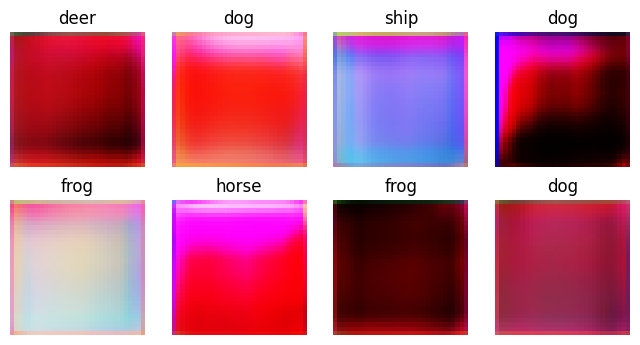

In [19]:
rand_labels = torch.randint(0, 10, (8,))
model.eval()
with torch.inference_mode():
    gen_imgs = model(rand_labels)
show_imgs(gen_imgs, rand_labels)

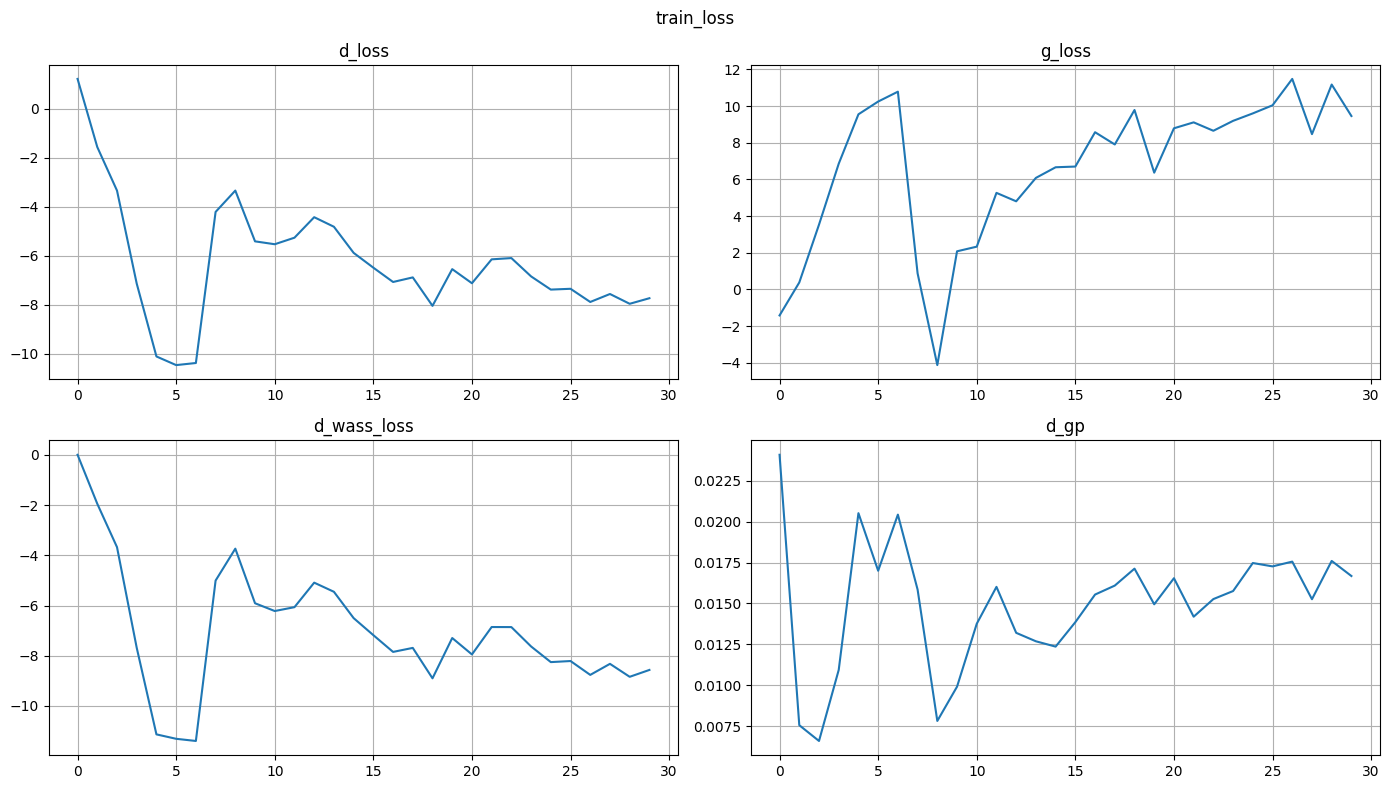

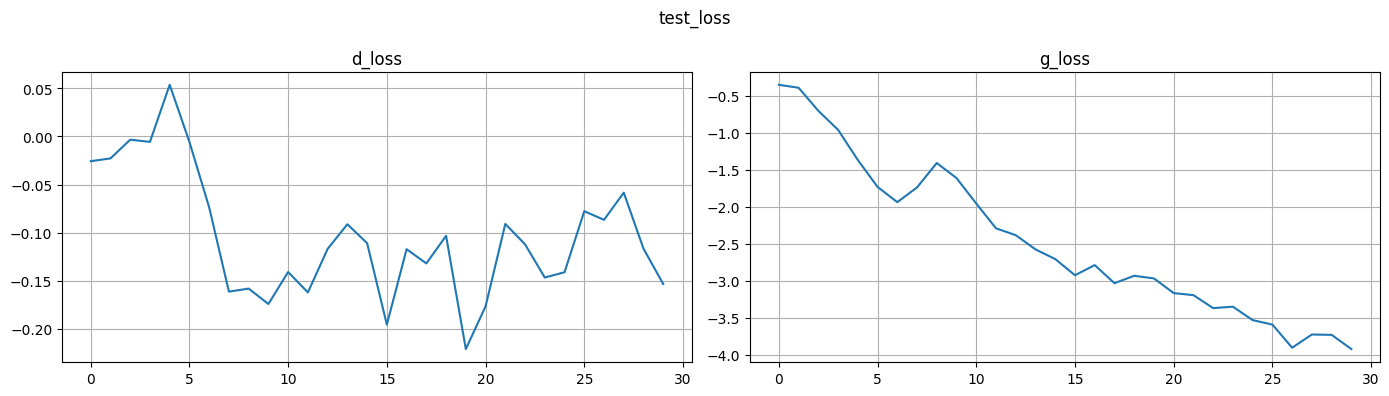

In [20]:
def plot(results, subs, title, train=True):
    section = 'train_loss' if train else 'test_loss'
    plt.subplot(int(subs))
    plt.plot(results[section][title])
    plt.title(title)
    plt.suptitle(section)
    plt.tight_layout()
    plt.grid(True)
    
##############
# Train Losses
##############
plt.figure(figsize=(14, 8))
plot(results, '221', 'd_loss')
plot(results, '222', 'g_loss')
plot(results, '223', 'd_wass_loss')
plot(results, '224', 'd_gp')
plt.show()

#############
# Test Losses
#############
plt.figure(figsize=(14, 4))
plot(results, '121', 'd_loss', False)
plot(results, '122', 'g_loss', False)
plt.show()